In [316]:
import pandas as pd
train_data = pd.read_csv('data/train.csv')

train_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [317]:
f"Columns: {train_data.shape}"

'Columns: (891, 12)'

In [320]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def normalize_df(df):
    scaler = StandardScaler()
    minmax_scaler = MinMaxScaler()

    df['Age'] = df['Age'].fillna(df['Age'].mean())
    # df['Age'] = df['Age'] / 100
    # df['Fare'] = df['Fare'] / 100
    df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])
    df['IsMale'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)
    #df['IsFirstClass'] = df['Pclass'].apply(lambda x: 1 if x == 1 else 0)
    #df['IsSecondClass'] = df['Pclass'].apply(lambda x: 1 if x == 2 else 0)
    df['Pclass'] = minmax_scaler.fit_transform(df[['Pclass']])
    df['EmbSouth'] = df['Embarked'].apply(lambda x: 1 if x == 'S' else 0)
    df['EmbQueen'] = df['Embarked'].apply(lambda x: 1 if x == 'Q' else 0)
    df['WithFamily'] = df['SibSp'].apply(lambda x: 1 if x > 0 else 0)
    df['WithParOrSb'] = df['Parch'].apply(lambda x: 1 if x > 0 else 0)
    df = df.drop(columns=['Ticket', 'Cabin', 'SibSp', 'Parch'])
    df = df.drop(columns=['PassengerId', 'Name', 'Sex', 'Embarked'])
    return df

data = normalize_df(train_data)
data

,Survived,Pclass,Age,Fare,IsMale,EmbSouth,EmbQueen,WithFamily,WithParOrSb
0,0,1.0,-5.924806e-01,-0.502445,1,1,0,1,0
1,1,0.0,6.387890e-01,0.786845,0,0,0,1,0
2,1,1.0,-2.846632e-01,-0.488854,0,1,0,0,0
3,1,0.0,4.079260e-01,0.420730,0,1,0,1,0
4,0,1.0,4.079260e-01,-0.486337,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
886,0,0.5,-2.077088e-01,-0.386671,1,1,0,0,0
887,1,0.0,-8.233437e-01,-0.044381,0,1,0,0,0
888,0,1.0,-1.834173e-16,-0.176263,0,1,0,1,1
889,1,0.0,-2.846632e-01,-0.044381,1,0,0,0,0


In [321]:
from torch import tensor, float32, randn, nn

w_size = len(data.columns) - 1
weights = nn.Parameter(randn(w_size) * 0.01)
entries = tensor(data.values, dtype=float32)

weights

Parameter containing:
tensor([ 0.0093, -0.0062, -0.0114,  0.0044, -0.0219, -0.0024, -0.0197,  0.0028],
       requires_grad=True)

In [325]:
from torch import dot, sigmoid, nn, optim

def calc_new_weights(in_t, w_t, target):
    dot_prod = dot(in_t, w_t)
    norm = sigmoid(dot_prod)
    loss = nn.functional.mse_loss(norm, target)
    loss.backward()
    # nn.utils.clip_grad_norm_([weights], max_norm=1.0)
    return loss

los_hist = []
print(weights)
optimizer = optim.Adam([weights], 0.001)

min_iter = 100
stop_loss = 0.08

for i in range(len(data.values)):
    row = entries[i:i+1].flatten()
    cur_loss = calc_new_weights(row[1:], weights, row[0])
    los_hist.append(cur_loss.item())
    optimizer.step()
    optimizer.zero_grad()
    if i > min_iter and cur_loss <= stop_loss:
        break

Parameter containing:
tensor([-0.1399, -0.0431,  0.1084, -0.2583, -0.1210, -0.0072, -0.0042,  0.0315],
       requires_grad=True)


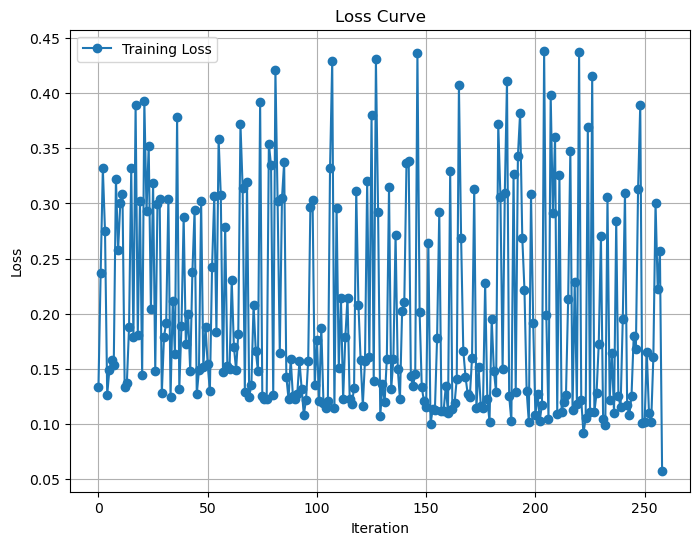

0.057678136974573135


In [326]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(len(los_hist)), los_hist, marker='o', linestyle='-', label='Training Loss')
plt.title("Loss Curve")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print(los_hist[len(los_hist) - 1])

In [327]:
weights

Parameter containing:
tensor([-0.1789, -0.0686,  0.1229, -0.3693, -0.1586,  0.0057, -0.0180,  0.0224],
       requires_grad=True)

In [328]:
import pandas as pd
test_data = pd.read_csv('data/test.csv')

test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [330]:
test_data_norm = normalize_df(test_data)
test_data_norm

,Pclass,Age,Fare,IsMale,EmbSouth,EmbQueen,WithFamily,WithParOrSb
0,1.0,3.349926e-01,-0.497811,1,0,1,0,0
1,1.0,1.325530e+00,-0.512660,0,1,0,1,0
2,0.5,2.514175e+00,-0.464532,1,0,1,0,0
3,1.0,-2.593299e-01,-0.482888,1,1,0,0,0
4,1.0,-6.555448e-01,-0.417971,0,1,0,1,1
...,...,...,...,...,...,...,...,...
413,1.0,-3.187243e-17,-0.493856,1,1,0,0,0
414,0.0,6.915861e-01,1.312180,0,0,0,0,0
415,1.0,6.519646e-01,-0.508183,1,1,0,0,0
416,1.0,-3.187243e-17,-0.493856,1,1,0,0,0


In [332]:
test_data_norm.shape

(418, 8)

In [339]:
import numpy as np

test_data_np = test_data_norm.to_numpy()
weights_np = weights.detach().numpy()

test_data_norm['Survived'] = test_data_norm['Survived'].apply(lambda x: 1 if abs(x) > 0.5 else 0)
test_data_norm


,Pclass,Age,Fare,IsMale,EmbSouth,EmbQueen,WithFamily,WithParOrSb,Survived
0,1.0,3.349926e-01,-0.497811,1,0,1,0,0,1
1,1.0,1.325530e+00,-0.512660,0,1,0,1,0,1
2,0.5,2.514175e+00,-0.464532,1,0,1,0,0,1
3,1.0,-2.593299e-01,-0.482888,1,1,0,0,0,1
4,1.0,-6.555448e-01,-0.417971,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...
413,1.0,-3.187243e-17,-0.493856,1,1,0,0,0,1
414,0.0,6.915861e-01,1.312180,0,0,0,0,0,0
415,1.0,6.519646e-01,-0.508183,1,1,0,0,0,1
416,1.0,-3.187243e-17,-0.493856,1,1,0,0,0,1


In [346]:
start_num = 892
test_data_norm['PassengerId'] = range(start_num, start_num + len(test_data_norm))

test_data_norm.to_csv('answer.csv', columns=['PassengerId', 'Survived'], index=False)